In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics
from AdaptiveALMA import AdaptiveALMA

from river import stream, compose, drift
from river import preprocessing
from river import optim
from river import linear_model as ln
%matplotlib inline

In [2]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_DDoS_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({1: 49396, 0: 24301})


In [3]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [4]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      74.16%   75.14%   74.65%     16575  
       1      87.59%   87.02%   87.30%     33425  
                                                  
   Macro      80.88%   81.08%   80.98%            
   Micro      83.08%   83.08%   83.08%            
Weighted      83.14%   83.08%   83.11%            

                 83.08% accuracy                   – 00:00:05 – 14.02 KB
[73,697]            Precision   Recall   F1       Support  
                                                  
       0      74.50%   75.28%   74.89%     24301  
       1      87.77%   87.33%   87.55%     49396  
                                                  
   Macro      81.14%   81.30%   81.22%            
   Micro      83.35%   83.35%   83.35%            
Weighted      83.40%   83.35%   83.38%            

                 83.35% accuracy                   – 00:00:08 – 14.02 KB
CPU times: user 8.

           Precision   Recall   F1       Support  
                                                  
       0      74.50%   75.28%   74.89%     24301  
       1      87.77%   87.33%   87.55%     49396  
                                                  
   Macro      81.14%   81.30%   81.22%            
   Micro      83.35%   83.35%   83.35%            
Weighted      83.40%   83.35%   83.38%            

                 83.35% accuracy                  

In [5]:
dataset = stream.iter_pandas(X, y)

In [6]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [7]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      80.13%   70.73%   75.14%     16575  
       1      86.28%   91.30%   88.72%     33425  
                                                  
   Macro      83.21%   81.01%   81.93%            
   Micro      84.48%   84.48%   84.48%            
Weighted      84.24%   84.48%   84.22%            

                 84.48% accuracy                   – 00:00:05 – 21.05 KB
[73,697]            Precision   Recall   F1       Support  
                                                  
       0      79.86%   70.93%   75.13%     24301  
       1      86.44%   91.20%   88.76%     49396  
                                                  
   Macro      83.15%   81.06%   81.94%            
   Micro      84.52%   84.52%   84.52%            
Weighted      84.27%   84.52%   84.26%            

                 84.52% accuracy                   – 00:00:08 – 21.47 KB
CPU times: user 8.

           Precision   Recall   F1       Support  
                                                  
       0      79.86%   70.93%   75.13%     24301  
       1      86.44%   91.20%   88.76%     49396  
                                                  
   Macro      83.15%   81.06%   81.94%            
   Micro      84.52%   84.52%   84.52%            
Weighted      84.27%   84.52%   84.26%            

                 84.52% accuracy                  

In [8]:
dataset = stream.iter_pandas(X, y)

In [9]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('DDoS_EdgeIIoT.png')
    plt.close()

    return fig

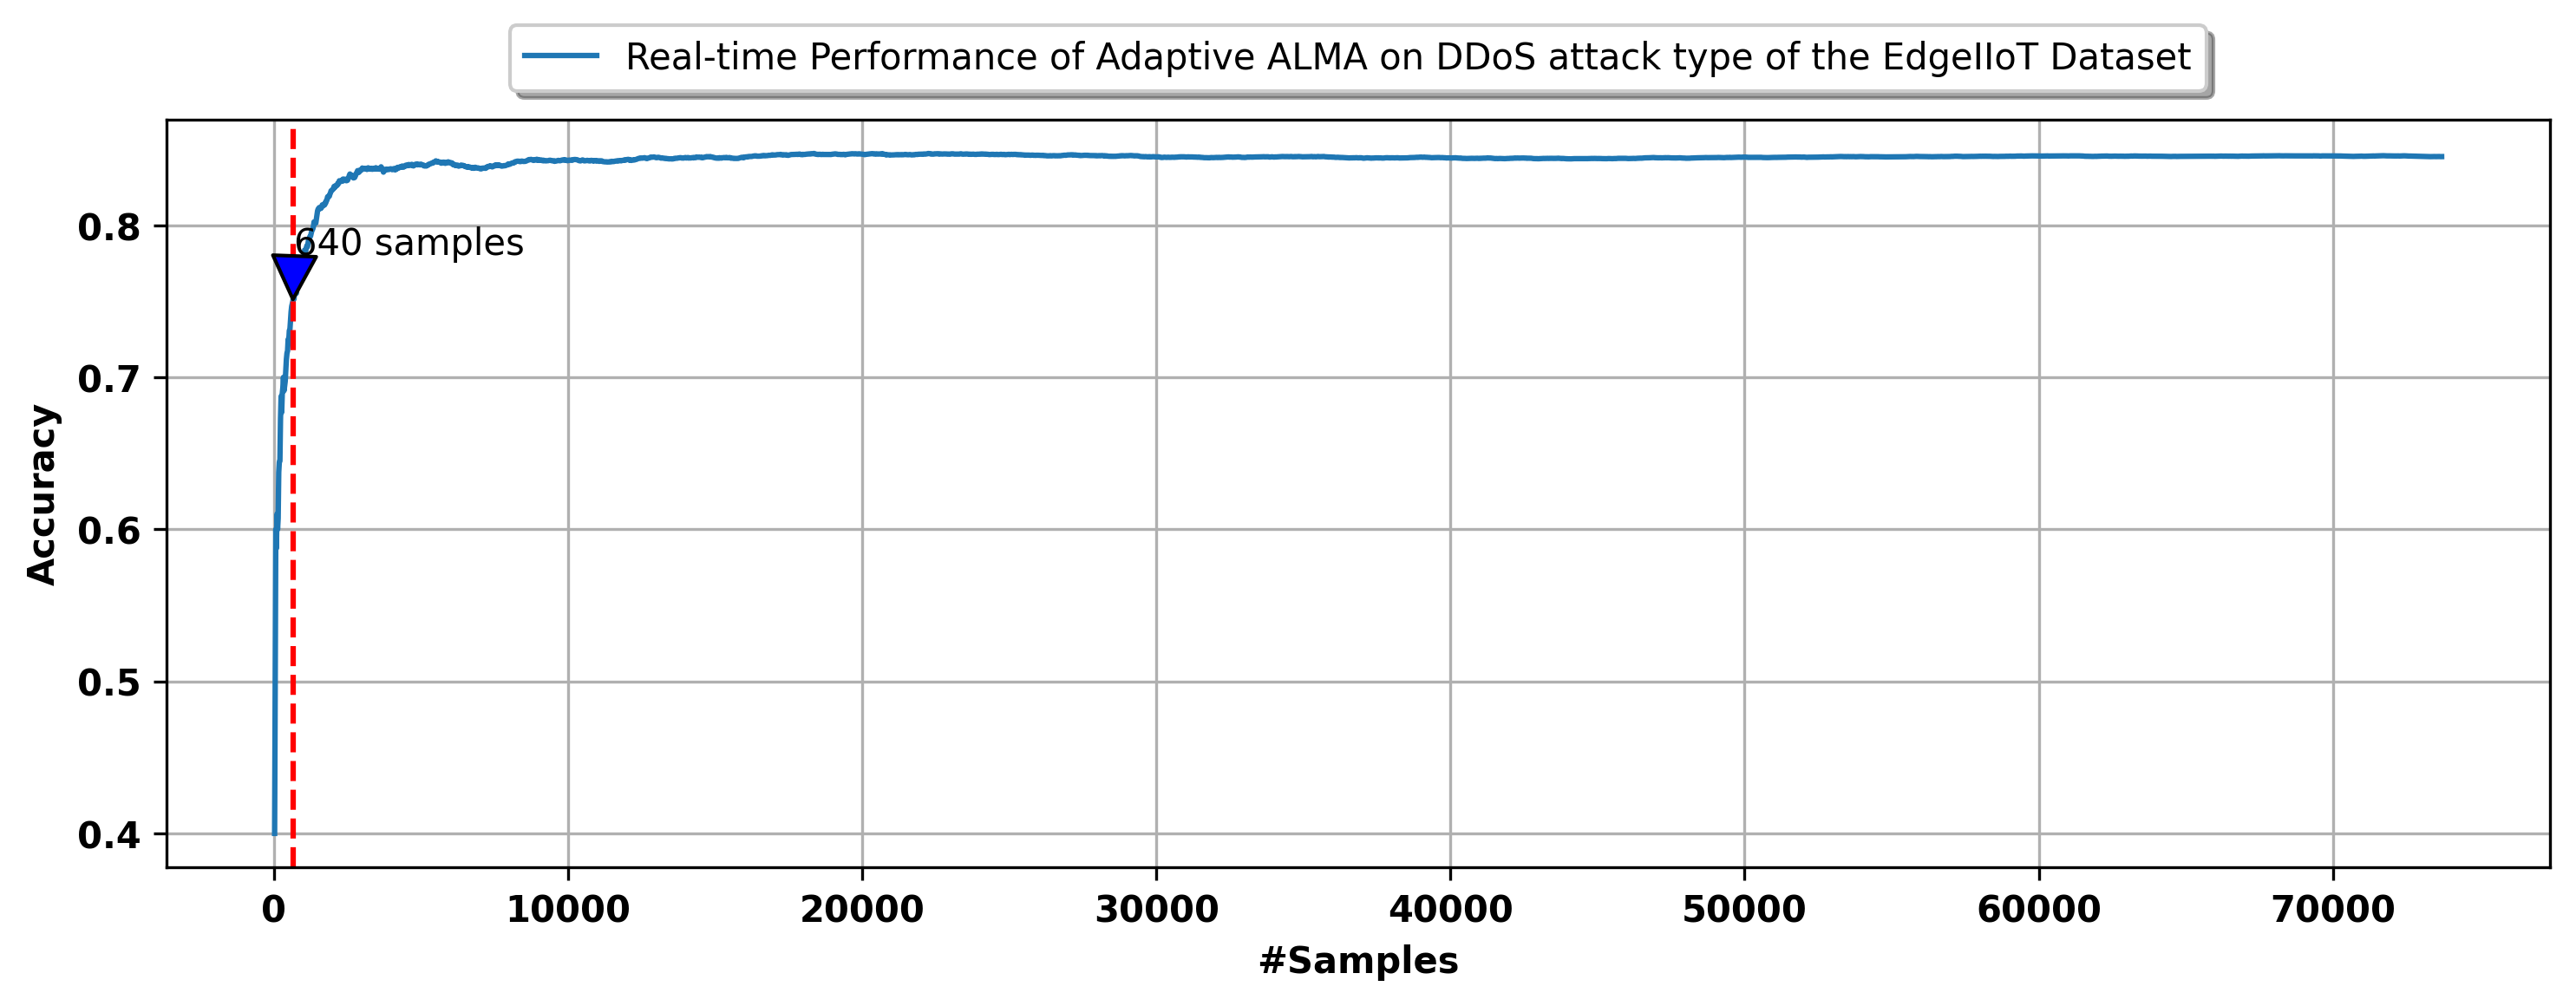

In [10]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on DDoS attack type of the EdgeIIoT Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [11]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_IG_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({0: 24301, 1: 21148})


In [12]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [13]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=10000, show_time=True, show_memory=True)

[10,000]            Precision   Recall   F1       Support  
                                                  
       0      87.17%   85.43%   86.29%      5386  
       1      83.38%   85.33%   84.34%      4614  
                                                  
   Macro      85.27%   85.38%   85.32%            
   Micro      85.38%   85.38%   85.38%            
Weighted      85.42%   85.38%   85.39%            

                 85.38% accuracy                   – 00:00:01 – 14.02 KB
[20,000]            Precision   Recall   F1       Support  
                                                  
       0      87.93%   86.93%   87.42%     10700  
       1      85.15%   86.27%   85.71%      9300  
                                                  
   Macro      86.54%   86.60%   86.57%            
   Micro      86.62%   86.62%   86.62%            
Weighted      86.64%   86.62%   86.63%            

                 86.62% accuracy                   – 00:00:02 – 14.02 KB
[30,000]          

           Precision   Recall   F1       Support  
                                                  
       0      88.12%   87.56%   87.84%     24301  
       1      85.81%   86.43%   86.12%     21148  
                                                  
   Macro      86.97%   87.00%   86.98%            
   Micro      87.04%   87.04%   87.04%            
Weighted      87.05%   87.04%   87.04%            

                 87.04% accuracy                  

In [14]:
dataset = stream.iter_pandas(X, y)

In [15]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [16]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=10000, show_time=True, show_memory=True)

[10,000]            Precision   Recall   F1       Support  
                                                  
       0      89.91%   93.28%   91.56%      5386  
       1      91.80%   87.78%   89.74%      4614  
                                                  
   Macro      90.85%   90.53%   90.65%            
   Micro      90.74%   90.74%   90.74%            
Weighted      90.78%   90.74%   90.72%            

                 90.74% accuracy                   – 00:00:01 – 20.9 KB
[20,000]            Precision   Recall   F1       Support  
                                                  
       0      90.65%   93.05%   91.83%     10700  
       1      91.75%   88.96%   90.33%      9300  
                                                  
   Macro      91.20%   91.00%   91.08%            
   Micro      91.14%   91.14%   91.14%            
Weighted      91.16%   91.14%   91.13%            

                 91.14% accuracy                   – 00:00:02 – 21.02 KB
[30,000]           

           Precision   Recall   F1       Support  
                                                  
       0      90.64%   92.87%   91.74%     24301  
       1      91.57%   88.98%   90.26%     21148  
                                                  
   Macro      91.10%   90.93%   91.00%            
   Micro      91.06%   91.06%   91.06%            
Weighted      91.07%   91.06%   91.05%            

                 91.06% accuracy                  

In [17]:
dataset = stream.iter_pandas(X, y)

In [18]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Information_EdgeIIoT.png')
    plt.close()

    return fig

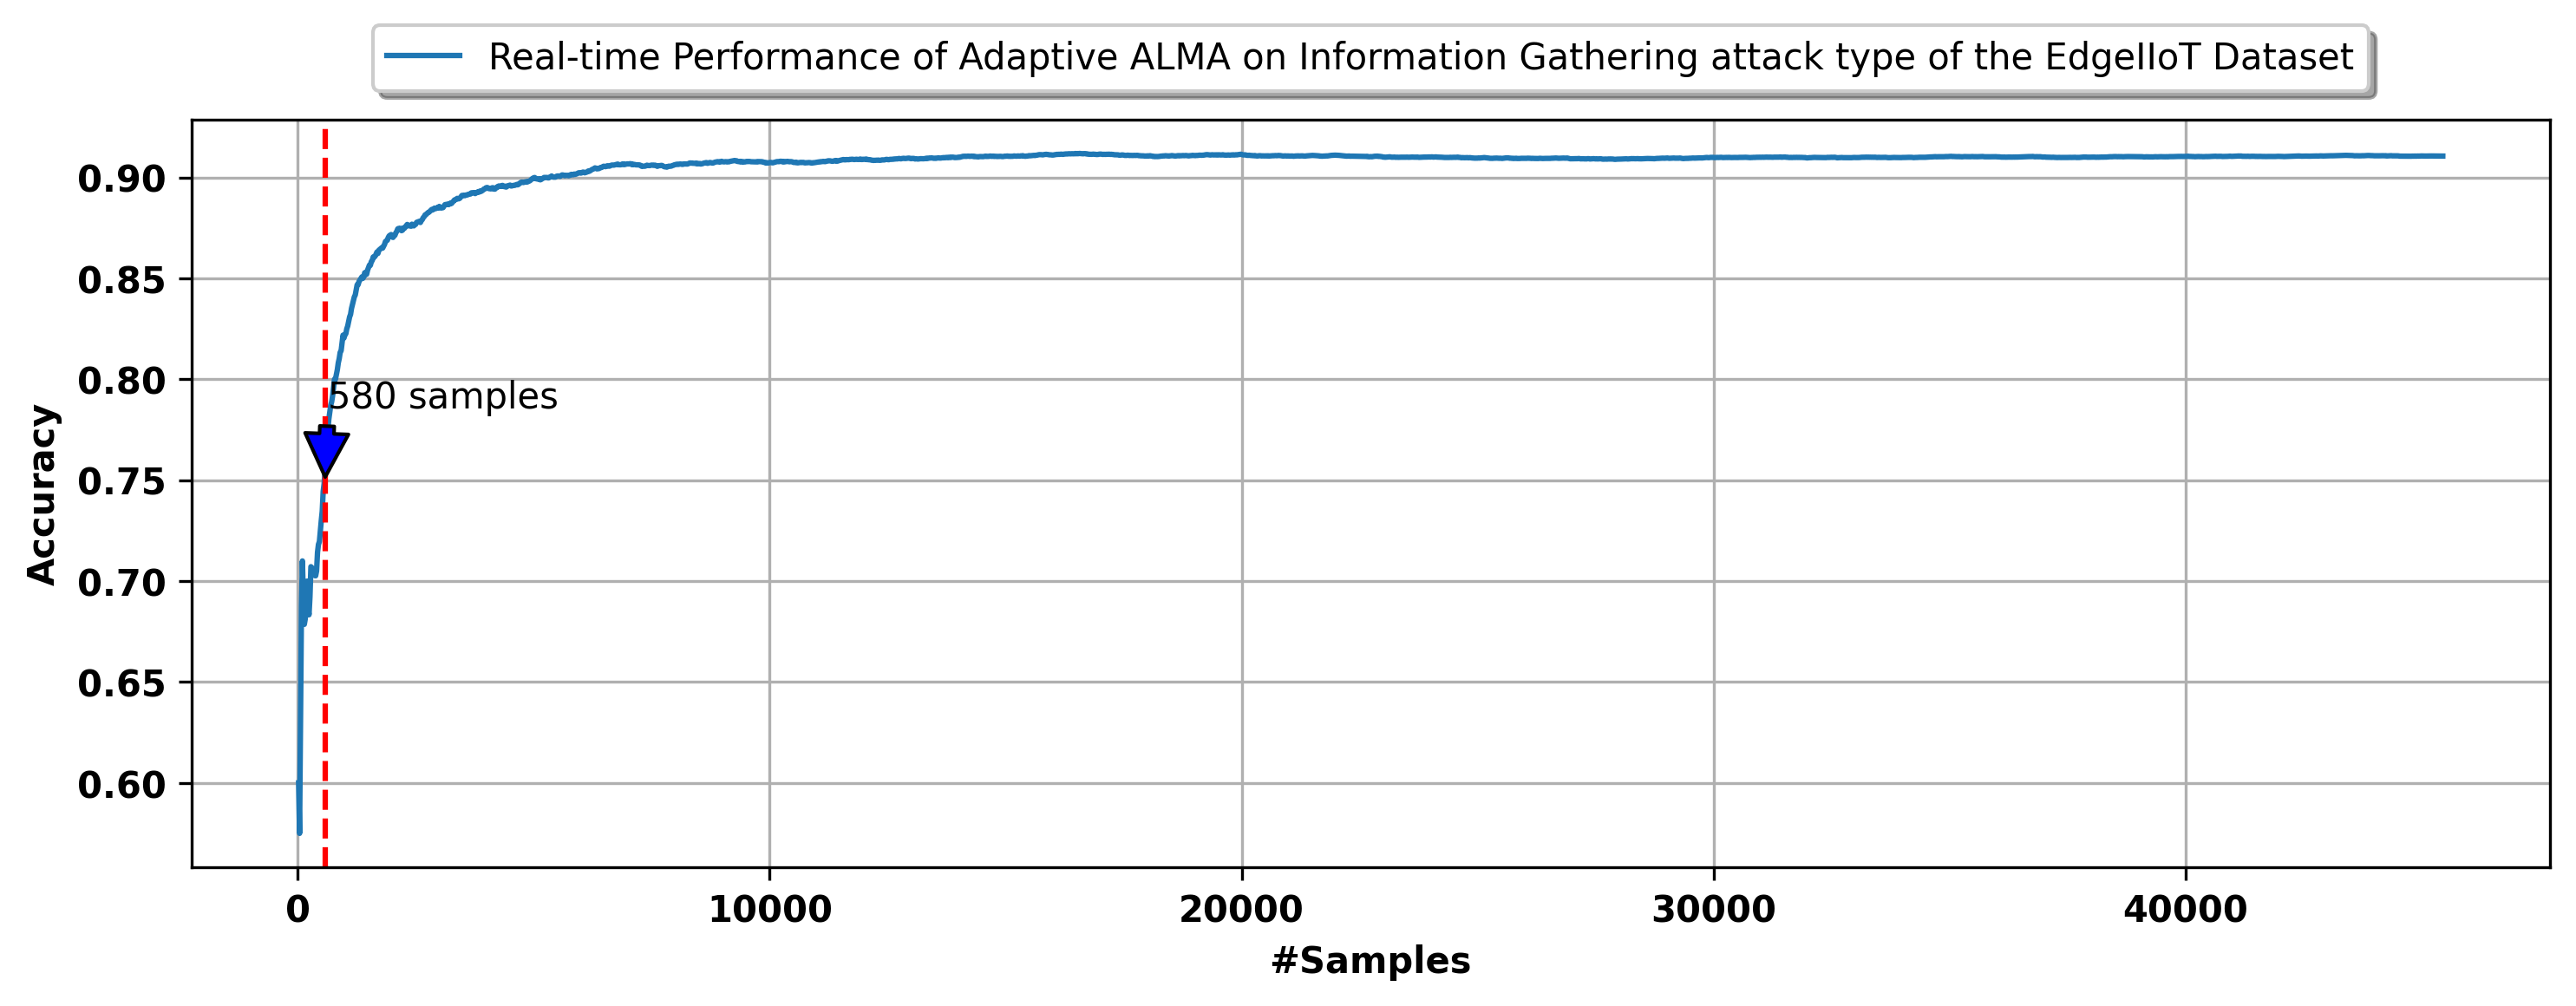

In [19]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on Information Gathering attack type of the EdgeIIoT Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [20]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Injection_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({1: 30632, 0: 24301})


In [21]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [22]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      63.23%   61.96%   62.59%     22191  
       1      70.12%   71.25%   70.68%     27809  
                                                  
   Macro      66.68%   66.60%   66.64%            
   Micro      67.13%   67.13%   67.13%            
Weighted      67.06%   67.13%   67.09%            

                 67.13% accuracy                   – 00:00:05 – 14.02 KB
[54,933]            Precision   Recall   F1       Support  
                                                  
       0      63.21%   61.96%   62.58%     24301  
       1      70.29%   71.39%   70.84%     30632  
                                                  
   Macro      66.75%   66.68%   66.71%            
   Micro      67.22%   67.22%   67.22%            
Weighted      67.16%   67.22%   67.18%            

                 67.22% accuracy                   – 00:00:06 – 14.02 KB
CPU times: user 6.

           Precision   Recall   F1       Support  
                                                  
       0      63.21%   61.96%   62.58%     24301  
       1      70.29%   71.39%   70.84%     30632  
                                                  
   Macro      66.75%   66.68%   66.71%            
   Micro      67.22%   67.22%   67.22%            
Weighted      67.16%   67.22%   67.18%            

                 67.22% accuracy                  

In [23]:
dataset = stream.iter_pandas(X, y)

In [24]:
Model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [25]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      53.70%   86.78%   66.34%     22191  
       1      79.25%   40.29%   53.42%     27809  
                                                  
   Macro      66.47%   63.53%   59.88%            
   Micro      60.92%   60.92%   60.92%            
Weighted      67.91%   60.92%   59.16%            

                 60.92% accuracy                   – 00:00:06 – 21.05 KB
[54,933]            Precision   Recall   F1       Support  
                                                  
       0      53.69%   86.23%   66.18%     24301  
       1      78.96%   41.00%   53.97%     30632  
                                                  
   Macro      66.33%   63.62%   60.08%            
   Micro      61.01%   61.01%   61.01%            
Weighted      67.78%   61.01%   59.37%            

                 61.01% accuracy                   – 00:00:07 – 21.13 KB
CPU times: user 7.

           Precision   Recall   F1       Support  
                                                  
       0      53.69%   86.23%   66.18%     24301  
       1      78.96%   41.00%   53.97%     30632  
                                                  
   Macro      66.33%   63.62%   60.08%            
   Micro      61.01%   61.01%   61.01%            
Weighted      67.78%   61.01%   59.37%            

                 61.01% accuracy                  

In [26]:
dataset = stream.iter_pandas(X, y)

In [27]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Injection_EdgeIIoT.png')
    plt.close()

    return fig

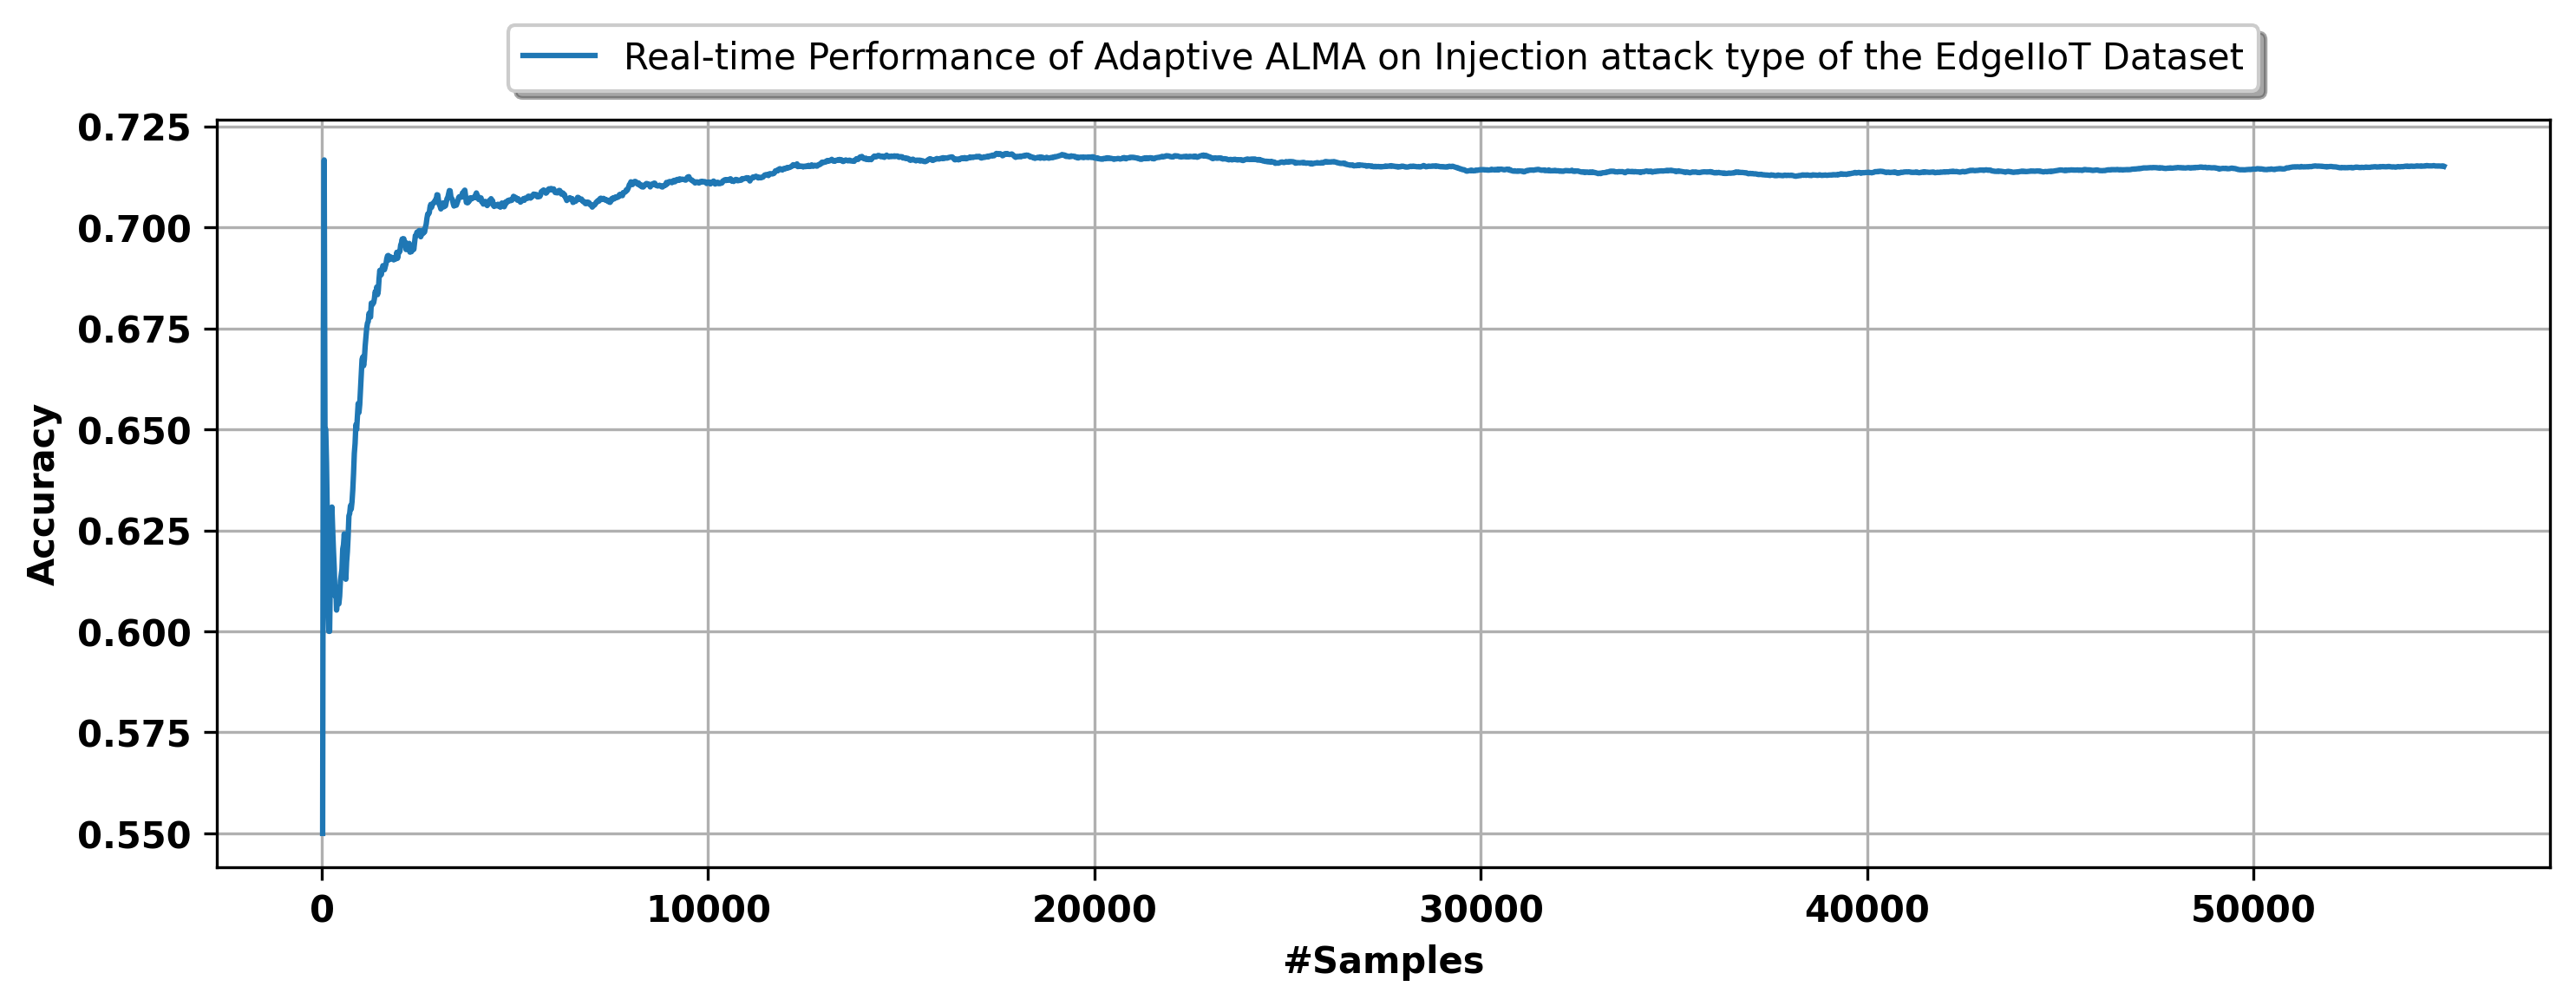

In [28]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on Injection attack type of the EdgeIIoT Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [29]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Malware_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)
dataset = stream.iter_pandas(X, y)

Original dataset shape  Counter({1: 31109, 0: 24301})


In [30]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [31]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      65.57%   63.33%   64.43%     21998  
       1      71.95%   73.87%   72.90%     28002  
                                                  
   Macro      68.76%   68.60%   68.66%            
   Micro      69.24%   69.24%   69.24%            
Weighted      69.14%   69.24%   69.17%            

                 69.24% accuracy                   – 00:00:05 – 14.02 KB
[55,410]            Precision   Recall   F1       Support  
                                                  
       0      65.49%   63.45%   64.46%     24301  
       1      72.13%   73.88%   72.99%     31109  
                                                  
   Macro      68.81%   68.67%   68.72%            
   Micro      69.31%   69.31%   69.31%            
Weighted      69.22%   69.31%   69.25%            

                 69.31% accuracy                   – 00:00:06 – 14.02 KB
CPU times: user 6.

           Precision   Recall   F1       Support  
                                                  
       0      65.49%   63.45%   64.46%     24301  
       1      72.13%   73.88%   72.99%     31109  
                                                  
   Macro      68.81%   68.67%   68.72%            
   Micro      69.31%   69.31%   69.31%            
Weighted      69.22%   69.31%   69.25%            

                 69.31% accuracy                  

In [32]:
dataset = stream.iter_pandas(X, y)

In [33]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [34]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      84.70%   45.81%   59.46%     21998  
       1      68.72%   93.50%   79.21%     28002  
                                                  
   Macro      76.71%   69.66%   69.34%            
   Micro      72.52%   72.52%   72.52%            
Weighted      75.75%   72.52%   70.53%            

                 72.52% accuracy                   – 00:00:05 – 21.03 KB
[55,410]            Precision   Recall   F1       Support  
                                                  
       0      84.79%   45.74%   59.42%     24301  
       1      68.83%   93.59%   79.32%     31109  
                                                  
   Macro      76.81%   69.66%   69.37%            
   Micro      72.60%   72.60%   72.60%            
Weighted      75.83%   72.60%   70.59%            

                 72.60% accuracy                   – 00:00:06 – 21.02 KB
CPU times: user 6.

           Precision   Recall   F1       Support  
                                                  
       0      84.79%   45.74%   59.42%     24301  
       1      68.83%   93.59%   79.32%     31109  
                                                  
   Macro      76.81%   69.66%   69.37%            
   Micro      72.60%   72.60%   72.60%            
Weighted      75.83%   72.60%   70.59%            

                 72.60% accuracy                  

In [35]:
dataset = stream.iter_pandas(X, y)

In [36]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Malware_EdgeIIoT.png')
    plt.close()

    return fig

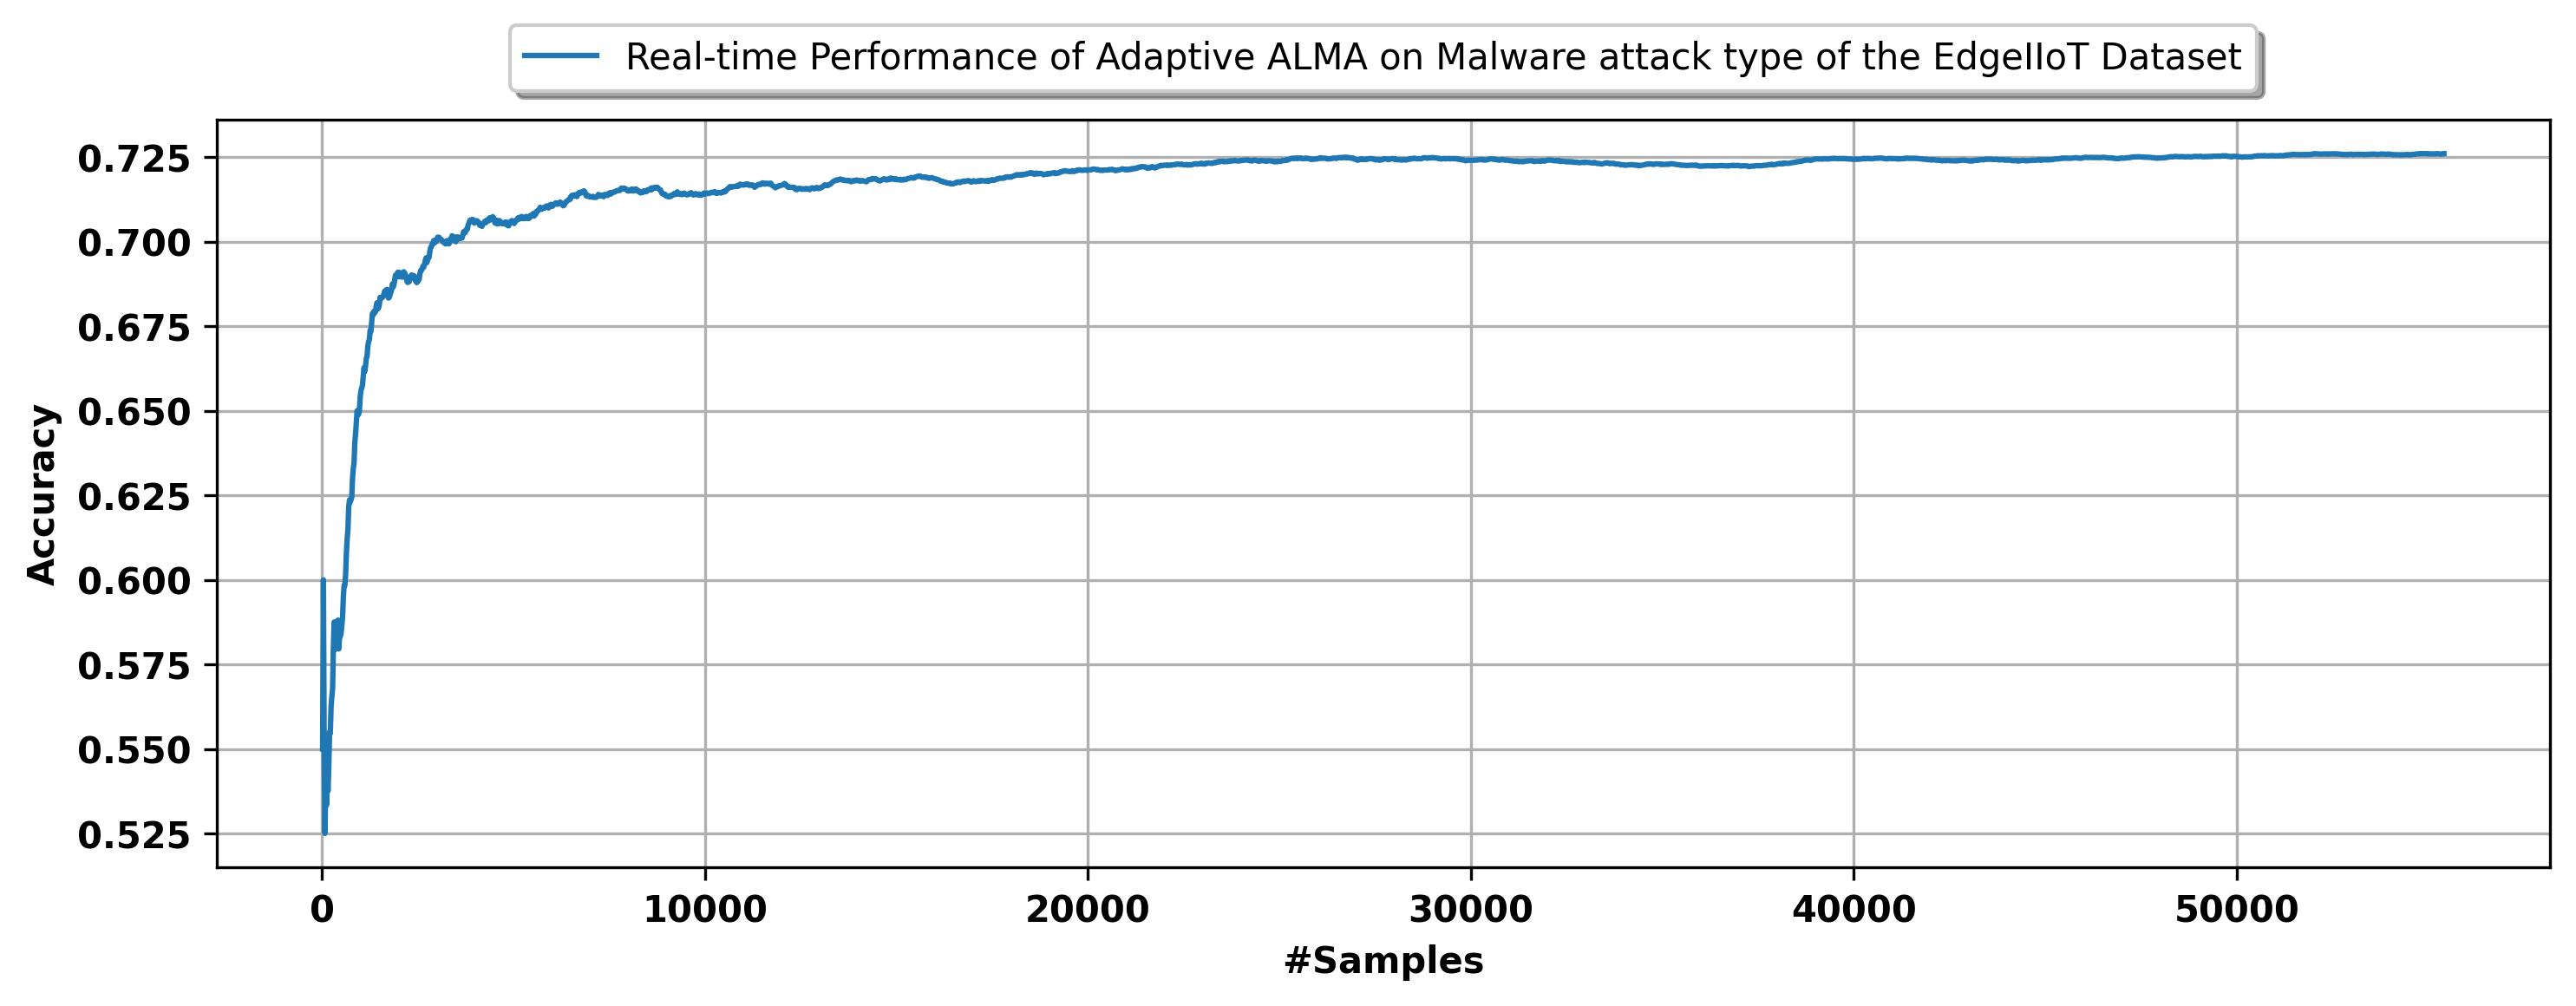

In [37]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on Malware attack type of the EdgeIIoT Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [38]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_DDoS_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Malware_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [39]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [40]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      80.04%   37.67%   51.23%     11426  
       1      84.04%   97.22%   90.15%     38574  
                                                  
   Macro      82.04%   67.44%   70.69%            
   Micro      83.61%   83.61%   83.61%            
Weighted      83.13%   83.61%   81.26%            

                 83.61% accuracy                   – 00:00:05 – 21.05 KB
[100,000]            Precision   Recall   F1       Support  
                                                  
       0      80.70%   37.26%   50.99%     23148  
       1      83.74%   97.32%   90.02%     76852  
                                                  
   Macro      82.22%   67.29%   70.50%            
   Micro      83.41%   83.41%   83.41%            
Weighted      83.04%   83.41%   80.98%            

                 83.41% accuracy                   – 00:00:11 – 21.05 KB
[104,806]        

           Precision   Recall   F1       Support  
                                                  
       0      80.75%   37.31%   51.04%     24301  
       1      83.72%   97.32%   90.01%     80505  
                                                  
   Macro      82.24%   67.31%   70.52%            
   Micro      83.40%   83.40%   83.40%            
Weighted      83.03%   83.40%   80.97%            

                 83.40% accuracy                  

In [41]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_DDoS_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Injection_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [42]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [43]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      74.95%   52.60%   61.81%     11455  
       1      87.06%   94.77%   90.75%     38545  
                                                  
   Macro      81.00%   73.69%   76.28%            
   Micro      85.11%   85.11%   85.11%            
Weighted      84.28%   85.11%   84.12%            

                 85.11% accuracy                   – 00:00:05 – 20.95 KB
[100,000]            Precision   Recall   F1       Support  
                                                  
       0      76.29%   52.65%   62.30%     23257  
       1      86.88%   95.04%   90.78%     76743  
                                                  
   Macro      81.59%   73.85%   76.54%            
   Micro      85.18%   85.18%   85.18%            
Weighted      84.42%   85.18%   84.16%            

                 85.18% accuracy                   – 00:00:11 – 20.9 KB
[104,329]         

           Precision   Recall   F1       Support  
                                                  
       0      76.43%   52.66%   62.35%     24301  
       1      86.86%   95.07%   90.78%     80028  
                                                  
   Macro      81.65%   73.86%   76.57%            
   Micro      85.19%   85.19%   85.19%            
Weighted      84.43%   85.19%   84.16%            

                 85.19% accuracy                  

In [44]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_DDoS_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_IG_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [45]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [46]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      64.27%   59.91%   62.01%     12641  
       1      86.74%   88.73%   87.72%     37359  
                                                  
   Macro      75.50%   74.32%   74.87%            
   Micro      81.44%   81.44%   81.44%            
Weighted      81.06%   81.44%   81.22%            

                 81.44% accuracy                   – 00:00:05 – 20.95 KB
[94,845]            Precision   Recall   F1       Support  
                                                  
       0      65.34%   59.85%   62.47%     24301  
       1      86.56%   89.06%   87.79%     70544  
                                                  
   Macro      75.95%   74.45%   75.13%            
   Micro      81.58%   81.58%   81.58%            
Weighted      81.12%   81.58%   81.30%            

                 81.58% accuracy                   – 00:00:11 – 21.08 KB
CPU times: user 11

           Precision   Recall   F1       Support  
                                                  
       0      65.34%   59.85%   62.47%     24301  
       1      86.56%   89.06%   87.79%     70544  
                                                  
   Macro      75.95%   74.45%   75.13%            
   Micro      81.58%   81.58%   81.58%            
Weighted      81.12%   81.58%   81.30%            

                 81.58% accuracy                  

In [47]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Malware_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Injection_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [48]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [49]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      66.22%   49.58%   56.70%     13927  
       1      82.26%   90.23%   86.06%     36073  
                                                  
   Macro      74.24%   69.91%   71.38%            
   Micro      78.91%   78.91%   78.91%            
Weighted      77.79%   78.91%   77.88%            

                 78.91% accuracy                   – 00:00:06 – 21.05 KB
[86,042]            Precision   Recall   F1       Support  
                                                  
       0      66.96%   49.92%   57.20%     24301  
       1      82.08%   90.31%   86.00%     61741  
                                                  
   Macro      74.52%   70.12%   71.60%            
   Micro      78.90%   78.90%   78.90%            
Weighted      77.81%   78.90%   77.87%            

                 78.90% accuracy                   – 00:00:10 – 21.08 KB
CPU times: user 10

           Precision   Recall   F1       Support  
                                                  
       0      66.96%   49.92%   57.20%     24301  
       1      82.08%   90.31%   86.00%     61741  
                                                  
   Macro      74.52%   70.12%   71.60%            
   Micro      78.90%   78.90%   78.90%            
Weighted      77.81%   78.90%   77.87%            

                 78.90% accuracy                  

In [50]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Malware_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_IG_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [51]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [52]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      70.68%   54.05%   61.26%     15747  
       1      80.94%   89.69%   85.09%     34253  
                                                  
   Macro      75.81%   71.87%   73.18%            
   Micro      78.47%   78.47%   78.47%            
Weighted      77.71%   78.47%   77.59%            

                 78.47% accuracy                   – 00:00:05 – 21.03 KB
[76,558]            Precision   Recall   F1       Support  
                                                  
       0      71.08%   53.31%   60.92%     24301  
       1      80.55%   89.91%   84.97%     52257  
                                                  
   Macro      75.81%   71.61%   72.95%            
   Micro      78.29%   78.29%   78.29%            
Weighted      77.54%   78.29%   77.34%            

                 78.29% accuracy                   – 00:00:08 – 21.08 KB
CPU times: user 8.

           Precision   Recall   F1       Support  
                                                  
       0      71.08%   53.31%   60.92%     24301  
       1      80.55%   89.91%   84.97%     52257  
                                                  
   Macro      75.81%   71.61%   72.95%            
   Micro      78.29%   78.29%   78.29%            
Weighted      77.54%   78.29%   77.34%            

                 78.29% accuracy                  

In [53]:
#Loading the dataset
df = pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Benign_Only.csv")
df1= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Injection_Only.csv")
df2= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_IG_Only.csv")
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X1 = df1.drop(['Attack_type'], axis=1)
y1 = df1['Attack_type']
X2 = df2.drop(['Attack_type'], axis=1)
y2 = df2['Attack_type']
X3 = pd.concat([X, X1, X2])
y3 = pd.concat([y, y1, y2])
X3, y3 = shuffle(X3, y3, random_state=42)
dataset = stream.iter_pandas(X3, y3)

In [54]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [55]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      57.27%   71.64%   63.66%     15843  
       1      85.11%   75.21%   79.86%     34157  
                                                  
   Macro      71.19%   73.43%   71.76%            
   Micro      74.08%   74.08%   74.08%            
Weighted      76.29%   74.08%   74.72%            

                 74.08% accuracy                   – 00:00:05 – 20.95 KB
[76,081]            Precision   Recall   F1       Support  
                                                  
       0      57.71%   70.93%   63.64%     24301  
       1      84.71%   75.60%   79.90%     51780  
                                                  
   Macro      71.21%   73.27%   71.77%            
   Micro      74.11%   74.11%   74.11%            
Weighted      76.09%   74.11%   74.71%            

                 74.11% accuracy                   – 00:00:08 – 21 KB
CPU times: user 8.92 

           Precision   Recall   F1       Support  
                                                  
       0      57.71%   70.93%   63.64%     24301  
       1      84.71%   75.60%   79.90%     51780  
                                                  
   Macro      71.21%   73.27%   71.77%            
   Micro      74.11%   74.11%   74.11%            
Weighted      76.09%   74.11%   74.71%            

                 74.11% accuracy                  

In [56]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_DDoS_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 49396, 0: 24301})


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [58]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 422 ms, sys: 3.63 ms, total: 425 ms
Wall time: 423 ms


           Precision   Recall   F1       Support  
                                                  
       0      68.86%   70.60%   69.72%      1187  
       1      85.85%   84.82%   85.33%      2497  
                                                  
   Macro      77.36%   77.71%   77.53%            
   Micro      80.24%   80.24%   80.24%            
Weighted      80.38%   80.24%   80.30%            

                 80.24% accuracy                  

In [59]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.8282747489751903
Precision: 0.8546904238873972
Recall: 0.8959679310859506
F1_Score: 0.8748425512424138


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [61]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      72.86%   76.66%   74.71%      1607  
       1      88.67%   86.47%   87.56%      3393  
                                                  
   Macro      80.76%   81.57%   81.13%            
   Micro      83.32%   83.32%   83.32%            
Weighted      83.59%   83.32%   83.43%            

                 83.32% accuracy                   – 00:00:00 – 20.92 KB
[7,369]            Precision   Recall   F1       Support  
                                                  
       0      74.12%   77.37%   75.71%      2373  
       1      89.02%   87.17%   88.09%      4996  
                                                  
   Macro      81.57%   82.27%   81.90%            
   Micro      84.01%   84.01%   84.01%            
Weighted      84.22%   84.01%   84.10%            

                 84.01% accuracy                   – 00:00:00 – 20.9 KB
CPU times: user 842 m

           Precision   Recall   F1       Support  
                                                  
       0      74.12%   77.37%   75.71%      2373  
       1      89.02%   87.17%   88.09%      4996  
                                                  
   Macro      81.57%   82.27%   81.90%            
   Micro      84.01%   84.01%   84.01%            
Weighted      84.22%   84.01%   84.10%            

                 84.01% accuracy                  

In [62]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.8566819442769268
Precision: 0.8931806913958624
Recall: 0.8926576576576577
F1_Score: 0.8929190979340798


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [64]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      68.29%   76.04%   71.96%      1603  
       1      88.06%   83.34%   85.63%      3397  
                                                  
   Macro      78.17%   79.69%   78.80%            
   Micro      81.00%   81.00%   81.00%            
Weighted      81.72%   81.00%   81.25%            

                 81.00% accuracy                   – 00:00:00 – 21.03 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      68.66%   75.24%   71.80%      3211  
       1      87.73%   83.75%   85.70%      6789  
                                                  
   Macro      78.19%   79.50%   78.75%            
   Micro      81.02%   81.02%   81.02%            
Weighted      81.61%   81.02%   81.23%            

                 81.02% accuracy                   – 00:00:01 – 20.92 KB
[11,054]           

           Precision   Recall   F1       Support  
                                                  
       0      68.55%   74.82%   71.55%      3571  
       1      87.44%   83.62%   85.48%      7483  
                                                  
   Macro      77.99%   79.22%   78.52%            
   Micro      80.78%   80.78%   80.78%            
Weighted      81.33%   80.78%   80.98%            

                 80.78% accuracy                  

In [65]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.8162284692623278
Precision: 0.8720597234120671
Recall: 0.8500465249445279
F1_Score: 0.8609124299246085


In [66]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Malware_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 31109, 0: 24301})


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [68]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 326 ms, sys: 3.61 ms, total: 330 ms
Wall time: 327 ms


           Precision   Recall   F1       Support  
                                                  
       0      69.31%   46.15%   55.40%      1233  
       1      65.93%   83.60%   73.72%      1537  
                                                  
   Macro      67.62%   64.88%   64.56%            
   Micro      66.93%   66.93%   66.93%            
Weighted      67.43%   66.93%   65.57%            

                 66.93% accuracy                  

In [69]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.6908434650455927
Precision: 0.6708551752492548
Recall: 0.8828283511429731
F1_Score: 0.7623817311061791


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [71]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      81.06%   44.22%   57.23%      2207  
       1      67.57%   91.84%   77.86%      2793  
                                                  
   Macro      74.32%   68.03%   67.54%            
   Micro      70.82%   70.82%   70.82%            
Weighted      73.53%   70.82%   68.75%            

                 70.82% accuracy                   – 00:00:00 – 21 KB
[5,541]            Precision   Recall   F1       Support  
                                                  
       0      81.19%   43.88%   56.97%      2420  
       1      67.92%   92.12%   78.19%      3121  
                                                  
   Macro      74.56%   68.00%   67.58%            
   Micro      71.05%   71.05%   71.05%            
Weighted      73.72%   71.05%   68.92%            

                 71.05% accuracy                   – 00:00:00 – 21.52 KB
CPU times: user 652 ms,

           Precision   Recall   F1       Support  
                                                  
       0      81.19%   43.88%   56.97%      2420  
       1      67.92%   92.12%   78.19%      3121  
                                                  
   Macro      74.56%   68.00%   67.58%            
   Micro      71.05%   71.05%   71.05%            
Weighted      73.72%   71.05%   68.92%            

                 71.05% accuracy                  

In [72]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.7173594818424271
Precision: 0.6813092161929372
Recall: 0.9326497070172931
F1_Score: 0.7874089380250675


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [74]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      80.61%   45.41%   58.10%      2224  
       1      67.60%   91.25%   77.66%      2776  
                                                  
   Macro      74.10%   68.33%   67.88%            
   Micro      70.86%   70.86%   70.86%            
Weighted      73.39%   70.86%   68.96%            

                 70.86% accuracy                   – 00:00:00 – 20.92 KB
[8,311]            Precision   Recall   F1       Support  
                                                  
       0      82.84%   45.15%   58.44%      3626  
       1      68.60%   92.76%   78.87%      4685  
                                                  
   Macro      75.72%   68.96%   68.66%            
   Micro      71.99%   71.99%   71.99%            
Weighted      74.82%   71.99%   69.96%            

                 71.99% accuracy                   – 00:00:00 – 21.08 KB
CPU times: user 981 

           Precision   Recall   F1       Support  
                                                  
       0      82.84%   45.15%   58.44%      3626  
       1      68.60%   92.76%   78.87%      4685  
                                                  
   Macro      75.72%   68.96%   68.66%            
   Micro      71.99%   71.99%   71.99%            
Weighted      74.82%   71.99%   69.96%            

                 71.99% accuracy                  

In [75]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.7240918066200981
Precision: 0.6841152759878253
Recall: 0.9441795337571904
F1_Score: 0.7933792313930007


In [76]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_IG_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({0: 24301, 1: 21148})


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [78]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 269 ms, sys: 2.45 ms, total: 272 ms
Wall time: 270 ms


           Precision   Recall   F1       Support  
                                                  
       0      88.40%   78.16%   82.97%      1209  
       1      78.05%   88.33%   82.88%      1063  
                                                  
   Macro      83.23%   83.25%   82.92%            
   Micro      82.92%   82.92%   82.92%            
Weighted      83.56%   82.92%   82.93%            

                 82.92% accuracy                  

In [79]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.8474882460569284
Precision: 0.7949659150498165
Recall: 0.9057505601194922
F1_Score: 0.8467499825455561


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [81]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 517 ms, sys: 3.54 ms, total: 520 ms
Wall time: 518 ms


           Precision   Recall   F1       Support  
                                                  
       0      89.30%   87.78%   88.53%      2414  
       1      86.41%   88.08%   87.24%      2130  
                                                  
   Macro      87.85%   87.93%   87.88%            
   Micro      87.92%   87.92%   87.92%            
Weighted      87.94%   87.92%   87.92%            

                 87.92% accuracy                  

In [82]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.8988387727661655
Precision: 0.8884711779448622
Recall: 0.894731307182669
F1_Score: 0.8915902541262771


In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [84]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      87.90%   82.02%   84.86%      2631  
       1      81.41%   87.46%   84.33%      2369  
                                                  
   Macro      84.66%   84.74%   84.60%            
   Micro      84.60%   84.60%   84.60%            
Weighted      84.83%   84.60%   84.61%            

                 84.60% accuracy                   – 00:00:00 – 20.95 KB
[6,817]            Precision   Recall   F1       Support  
                                                  
       0      88.61%   81.62%   84.97%      3640  
       1      80.69%   87.98%   84.17%      3177  
                                                  
   Macro      84.65%   84.80%   84.57%            
   Micro      84.58%   84.58%   84.58%            
Weighted      84.92%   84.58%   84.60%            

                 84.58% accuracy                   – 00:00:00 – 21.44 KB
CPU times: user 800 

           Precision   Recall   F1       Support  
                                                  
       0      88.61%   81.62%   84.97%      3640  
       1      80.69%   87.98%   84.17%      3177  
                                                  
   Macro      84.65%   84.80%   84.57%            
   Micro      84.58%   84.58%   84.58%            
Weighted      84.92%   84.58%   84.60%            

                 84.58% accuracy                  

In [85]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.8526610064195486
Precision: 0.8101227458705864
Recall: 0.8924378164821101
F1_Score: 0.8492904045753018


In [86]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/Edge_Injection_Attack.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 30632, 0: 24301})


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [88]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

CPU times: user 332 ms, sys: 4.8 ms, total: 337 ms
Wall time: 344 ms


           Precision   Recall   F1       Support  
                                                  
       0      78.43%   47.43%   59.11%      1204  
       1      68.63%   89.82%   77.81%      1542  
                                                  
   Macro      73.53%   68.62%   68.46%            
   Micro      71.23%   71.23%   71.23%            
Weighted      72.93%   71.23%   69.61%            

                 71.23% accuracy                  

In [89]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.7375016766627704
Precision: 0.6907707181635638
Recall: 0.9578893090409075
F1_Score: 0.8026905183712858


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [91]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      73.10%   58.97%   65.28%      2208  
       1      71.85%   82.84%   76.96%      2792  
                                                  
   Macro      72.48%   70.91%   71.12%            
   Micro      72.30%   72.30%   72.30%            
Weighted      72.41%   72.30%   71.80%            

                 72.30% accuracy                   – 00:00:00 – 20.95 KB
[5,493]            Precision   Recall   F1       Support  
                                                  
       0      73.01%   58.76%   65.12%      2408  
       1      72.07%   83.05%   77.17%      3085  
                                                  
   Macro      72.54%   70.90%   71.14%            
   Micro      72.40%   72.40%   72.40%            
Weighted      72.48%   72.40%   71.89%            

                 72.40% accuracy                   – 00:00:01 – 21.08 KB
CPU times: user 776 

           Precision   Recall   F1       Support  
                                                  
       0      73.01%   58.76%   65.12%      2408  
       1      72.07%   83.05%   77.17%      3085  
                                                  
   Macro      72.54%   70.90%   71.14%            
   Micro      72.40%   72.40%   72.40%            
Weighted      72.48%   72.40%   71.89%            

                 72.40% accuracy                  

In [92]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.7254045307443365
Precision: 0.722291169451074
Recall: 0.8239735724398302
F1_Score: 0.7697890524316625


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=df['Attack_type'])

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [94]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      76.31%   57.08%   65.31%      2218  
       1      71.51%   85.87%   78.03%      2782  
                                                  
   Macro      73.91%   71.48%   71.67%            
   Micro      73.10%   73.10%   73.10%            
Weighted      73.64%   73.10%   72.39%            

                 73.10% accuracy                   – 00:00:00 – 21.03 KB
[8,239]            Precision   Recall   F1       Support  
                                                  
       0      76.55%   56.15%   64.79%      3640  
       1      71.34%   86.39%   78.15%      4599  
                                                  
   Macro      73.95%   71.27%   71.47%            
   Micro      73.03%   73.03%   73.03%            
Weighted      73.64%   73.03%   72.24%            

                 73.03% accuracy                   – 00:00:00 – 21.49 KB
CPU times: user 964 

           Precision   Recall   F1       Support  
                                                  
       0      76.55%   56.15%   64.79%      3640  
       1      71.34%   86.39%   78.15%      4599  
                                                  
   Macro      73.95%   71.27%   71.47%            
   Micro      73.03%   73.03%   73.03%            
Weighted      73.64%   73.03%   72.24%            

                 73.03% accuracy                  

In [95]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.7364757784726089
Precision: 0.7168720379146919
Recall: 0.8715476510582721
F1_Score: 0.7866789175320285


In [96]:
#Loading the dataset
df= pd.read_csv("/Users/promisea/ALMA/EdgeIIoT/EdgeIIoT.csv")
print('Original dataset shape  %s' % Counter(df['Attack_type']))
X = df.drop(['Attack_type'], axis=1)
y = df['Attack_type']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 133499, 0: 24301})


In [97]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

dataset = stream.iter_pandas(X, y)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [98]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      28.84%   55.33%   37.91%       788  
       1      89.91%   74.45%   81.45%      4212  
                                                  
   Macro      59.37%   64.89%   59.68%            
   Micro      71.44%   71.44%   71.44%            
Weighted      80.28%   71.44%   74.59%            

                 71.44% accuracy                   – 00:00:00 – 14.02 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      33.11%   52.29%   40.54%      1597  
       1      89.81%   79.92%   84.58%      8403  
                                                  
   Macro      61.46%   66.10%   62.56%            
   Micro      75.51%   75.51%   75.51%            
Weighted      80.75%   75.51%   77.55%            

                 75.51% accuracy                   – 00:00:01 – 14.02 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      44.91%   46.69%   45.78%     24301  
       1      90.23%   89.58%   89.90%    133499  
                                                  
   Macro      67.57%   68.13%   67.84%            
   Micro      82.97%   82.97%   82.97%            
Weighted      83.25%   82.97%   83.11%            

                 82.97% accuracy                  

In [99]:
dataset = stream.iter_pandas(X, y)

In [100]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X, y)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [101]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=5000, show_time=True, show_memory=True)

[5,000]            Precision   Recall   F1       Support  
                                                  
       0      45.08%   48.22%   46.60%       788  
       1      90.19%   89.01%   89.59%      4212  
                                                  
   Macro      67.63%   68.62%   68.09%            
   Micro      82.58%   82.58%   82.58%            
Weighted      83.08%   82.58%   82.82%            

                 82.58% accuracy                   – 00:00:00 – 20.98 KB
[10,000]            Precision   Recall   F1       Support  
                                                  
       0      46.78%   46.46%   46.62%      1597  
       1      89.84%   89.96%   89.90%      8403  
                                                  
   Macro      68.31%   68.21%   68.26%            
   Micro      83.01%   83.01%   83.01%            
Weighted      82.96%   83.01%   82.99%            

                 83.01% accuracy                   – 00:00:01 – 21.02 KB
[15,000]           

           Precision   Recall   F1       Support  
                                                  
       0      49.93%   45.69%   47.72%     24301  
       1      90.26%   91.66%   90.96%    133499  
                                                  
   Macro      70.10%   68.68%   69.34%            
   Micro      84.58%   84.58%   84.58%            
Weighted      84.05%   84.58%   84.30%            

                 84.58% accuracy                  

In [102]:
dataset = stream.iter_pandas(X, y)

In [103]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('#Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Performance_ALMA_EdgeIIoT.png')
    plt.close()

    return fig

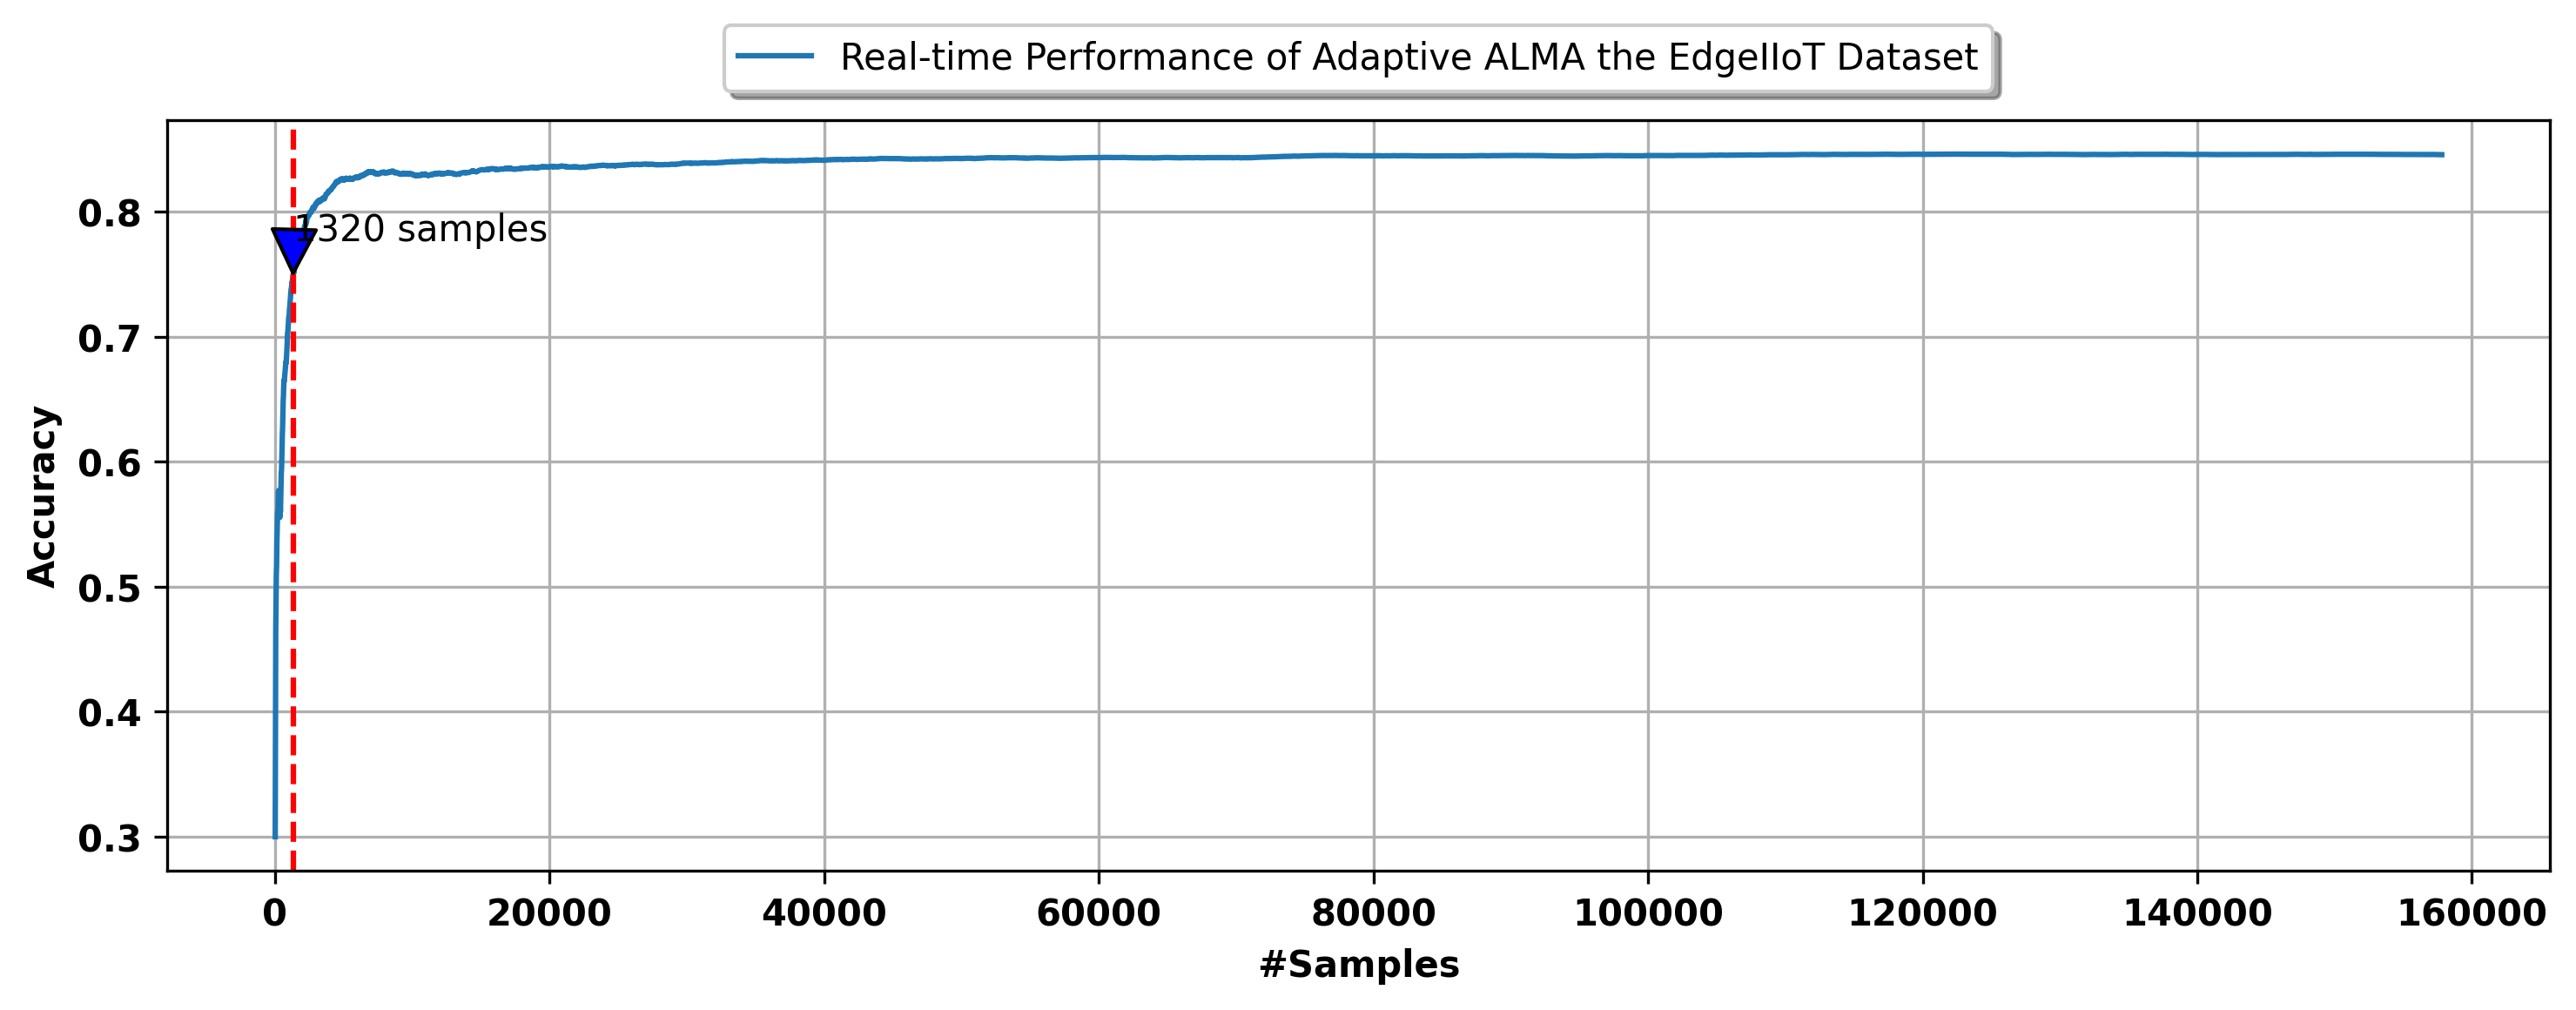

In [104]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA the EdgeIIoT Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)